# Bike-Share Demand Forecasting 2b: SageMaker DeepAR Algorithm

이전 [1_Data_Preparation](1_Data_Preparation.ipynb) 노트북에서 수행한 bike-share 수요 예측 문제를 해결하기 위해 3가지 방법을 살펴봅니다.

1. AWS "Managed AI"서비스 ([Amazon Forecast] (https://aws.amazon.com/forecast/))으로 일반적/규격화된 비즈니스 문제를 다룹니다.
2. SageMaker의 built-in된 알고리즘 ([DeepAR] (https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html))을 사용하여 1번과 동일한 비즈니스 문제를 다룹니다.
3. custom SageMaker 알고리즘을 사용하여 부가적인 차별적 SageMaker의 기능을 활용하면서 핵심 모델링을 수행합니다.


**이 노트북은 SageMaker의 built-in 알고리즘인 DeepAR을 적용하는 방법을 보여줍니다.**

**This notebook shows how to apply the SageMaker DeepAR built-in algorithm.**

## Dependencies and configuration

라이브러리를 로딩한 다음, 설정값을 정의하고, AWS SDKs에 연결합니다.

<h2><span style="color:red">첫번째 설치 이후 두번째 실행 시에는 False로 수정 후 진행하세요</span></h2>

In [1]:
install_needed = True  # should only be True once
# install_needed = False

In [2]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install -U sagemaker
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
# Basic data configuration is initialised and stored in the Data Preparation notebook
# ...We just retrieve it here:
%store -r
assert bucket, "Variable `bucket` missing from IPython store"

assert data_prefix, "Variable `data_prefix` missing from IPython store"
assert target_train_filename, "Variable `target_train_filename` missing from IPython store"
assert target_test_filename, "Variable `target_test_filename` missing from IPython store"
assert related_filename, "Variable `related_filename` missing from IPython store"

sm_train_filename = "train.json"
sm_test_filename = "test.json"
sm_inference_filename = "predict_input.json"

In [2]:
%load_ext autoreload
%autoreload 1

# Built-Ins:
from datetime import datetime, timedelta
import json
import time

# External Dependencies:
import boto3
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker

# Local Dependencies:
%aimport util

In [3]:
sagemaker.__version__

'2.91.1'

In [4]:
session = boto3.Session()
region = session.region_name
smsession = sagemaker.Session()
s3 = session.client(service_name="s3")

In [5]:
sm_role_arn = sagemaker.get_execution_role()

## Overview

## Step 1: Determine your algorithm details

이 문제에 대해 SageMaker DeepAR 알고리즘을 사용하려면, 알고리즘을 구성하고 원하는 형식의 데이터를 제공해야 합니다.

특히, 일부의 built-in 알고리즘은 [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html)에서 지원합니다.

```python
# 아래와 같은 방식을 지원합니다.
estimator = sagemaker.KMeans(...)
# 아직 아래 방식은 지원하지 않습니다.
estimator = sagemaker.DeepAR(...)
```

이런 경우에는 [SageMaker built-in algorithms common parameters doc](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)에서 리스트된 것과 같이 container image에 대한 URL을 제공합니다.

다행히 이 문제의 경우에는 copy/paste 대신에 이미지 경로에서 바로 가져올 수 있는 프로그래밍 방식의 방법이 있습니다. 하지만, 이 알고리즘이 GPU 가속을 지원하는지, 분산 학습이 가능한지, 다양한 입력과 출력 형식 등을 지원하는지에 대한 상세한 내용을 common parameters 문서에서 확인해야 할 필요는 있습니다.
더욱 상세한 내용에 대해서는 [DeepAR algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)에서 확인하시기 바랍니다.

In [6]:
training_image = sagemaker.image_uris.retrieve(
    "forecasting-deepar",
     region,
)
print(training_image)

522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


## Step 2: Prepare training data

common docs나 [DeepAR algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)에서 언급한 것처럼, DeepAR 알고리즘은 JSONLines 또는 Parquet 형식처럼 아래 형식의 학습 데이터가 필요합니다.

```json
{"start": "2009-11-01 00:00:00", "target": [target timeseries...], "cat": [categorical features...], "dynamic_feat": [[related TS 1...], [related TS 2...]}
{"start": "2009-11-02 00:00:00", "target": [target timeseries...], "cat": [categorical features...], "dynamic_feat": [[related TS 1...], [related TS 2...]}                                                                               ...
```

우리는 **1_Data_Preparation**에서 생성한 데이터 파일을 다시 가져와서 수행할 예정입니다.

In [7]:
target_train_df = pd.read_csv(f"./data/{target_train_filename}")
target_test_df = pd.read_csv(f"./data/{target_test_filename}")
related_df = pd.read_csv(f"./data/{related_filename}")

related_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01 00:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0
1,2011-01-01 01:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0
2,2011-01-01 02:00:00,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0
3,2011-01-01 03:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0
4,2011-01-01 04:00:00,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0


먼저, DeepAR에서는 숫자 형태의 `dynamic_feat`만 허용하므로 기존의 이진 형태의 related 데이터셋 내 필드 값들을 변경해야 합니다.

In [8]:
related_df["holiday"] = related_df["holiday"].astype(int)
related_df["workingday"] = related_df["workingday"].astype(int)

related_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01 00:00:00,1.0,0,6.0,0,1.0,0.24,0.2879,0.81,0.0
1,2011-01-01 01:00:00,1.0,0,6.0,0,1.0,0.22,0.2727,0.80,0.0
2,2011-01-01 02:00:00,1.0,0,6.0,0,1.0,0.22,0.2727,0.80,0.0
3,2011-01-01 03:00:00,1.0,0,6.0,0,1.0,0.24,0.2879,0.75,0.0
4,2011-01-01 04:00:00,1.0,0,6.0,0,1.0,0.24,0.2879,0.75,0.0


이전 과정에서 **target** timeseries 를 training과 test 데이터셋으로 분리하였고, 하나의 큰 리스트로 **related** 데이터셋으로 만들었습니다.

[best practices](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar_best_practices) 문서를 보시면, SageMaker DeepAR은 조금 다른 형태를 원하는 것을 알 수 있습니다.

* 학습 시 `train` 데이터 셋에는 학습 기간에 대한 *target* + *related* 데이터 
* 학습 시 `test` 데이터 셋에는 학습 및 테스트 기간 포함 전체 *target* + *related* 데이터
* **inference** 데이터셋에는 학습 기간 *target* series와 전체 기간의 *related* series 데이터 필요

In [9]:
first_test_ts = target_test_df["timestamp"][0]
related_train_df = related_df[related_df["timestamp"] < first_test_ts]
related_test_df = related_df[related_df["timestamp"] >= first_test_ts]

training과 test 데이터셋을 target 포맷으로 변경합니다.

In [10]:
# We'll loop through our customer types creating a record for each:
customer_types = target_train_df["customer_type"].unique()

# Related timeseries are general, not per-custtype, so we can format out here:
dynamic_feats_train = related_train_df.drop(columns="timestamp")
dynamic_feats_train = [dynamic_feats_train[col].to_list() for col in dynamic_feats_train.columns]
dynamic_feats_test = related_test_df.drop(columns="timestamp")
dynamic_feats_test = [dynamic_feats_test[col].to_list() for col in dynamic_feats_test.columns]

# Training data set (training timestamps only):
train_lines = []
# Test data set (training + test timestamps):
test_lines = []
# Inference data set (training target + full related series):
inference_lines = []

for customer_type in customer_types:
    ctmr_target_train_df = target_train_df[target_train_df["customer_type"] == customer_type]
    target_train = ctmr_target_train_df["demand"].to_list()
    target_test = target_test_df[target_test_df["customer_type"] == customer_type]["demand"].to_list()
    
    train_lines.append({
        "start": ctmr_target_train_df["timestamp"].iloc[0],
        "target": target_train,
        "dynamic_feat": dynamic_feats_train
    })
    test_lines.append({
        "start": ctmr_target_train_df["timestamp"].iloc[0],
        "target": target_train + target_test,
        "dynamic_feat": [
            dynamic_feats_train[ixf] + dynamic_feats_test[ixf] for ixf in range(len(dynamic_feats_train))
        ]
    })
    inference_lines.append({
        "start": ctmr_target_train_df["timestamp"].iloc[0],
        "target": target_train,
        "dynamic_feat": [
            dynamic_feats_train[ixf] + dynamic_feats_test[ixf] for ixf in range(len(dynamic_feats_train))
        ]
    })

*JSON Lines* 형식은 JSON이지만, `[... , ...]` 배열 대신 줄바꿈 형식으로 각 데이터 분리되어 저장됩니다. 따라서, 전체 JSON Lines 파일은 *유효한 JSON 타입이 아니며*, 파일의 각각 라인만이 *유효한 JSON 타입* 입니다.

JSON Line 형식으로 학습과 테스트 파일을 작성한 다음, S3로 업로드를 합니다.


In [11]:
from pandas import json_normalize
import numpy as np
json_normalize(train_lines)

,start,target,dynamic_feat
0,2011-01-01 00:00:00,"[3.0, 8.0, 5.0, 3.0, 0.0, 0.0, 2.0, 1.0, 1.0, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,2011-01-01 00:00:00,"[13.0, 32.0, 27.0, 10.0, 1.0, 1.0, 0.0, 2.0, 7...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [12]:
np.array(train_lines[0]['target']).shape, np.array(train_lines[0]['dynamic_feat']).shape

((16800,), (9, 16800))

In [13]:
print("Writing data sets to file...")
!mkdir -p ./data/smdeepar

with open(f"./data/smdeepar/{sm_train_filename}", "w") as f:
    for ix in range(len(train_lines)):
        if (ix > 0):
            f.write("\n")
        f.write(json.dumps(train_lines[ix]))

with open(f"./data/smdeepar/{sm_test_filename}", "w") as f:
    for ix in range(len(test_lines)):
        if (ix > 0):
            f.write("\n")
        f.write(json.dumps(test_lines[ix]))

with open(f"./data/smdeepar/{sm_inference_filename}", "w") as f:
    for ix in range(len(inference_lines)):
        if (ix > 0):
            f.write("\n")
        f.write(json.dumps(inference_lines[ix]))

print("Uploading dataframes to S3...")
s3.upload_file(
    Filename=f"./data/smdeepar/{sm_train_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}smdeepar/{sm_train_filename}"
)
print(f"s3://{bucket}/{data_prefix}smdeepar/{sm_train_filename}")
s3.upload_file(
    Filename=f"./data/smdeepar/{sm_test_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}smdeepar/{sm_test_filename}"
)
print(f"s3://{bucket}/{data_prefix}smdeepar/{sm_test_filename}")
s3.upload_file(
    Filename=f"./data/smdeepar/{sm_inference_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}smdeepar/{sm_inference_filename}"
)
print(f"s3://{bucket}/{data_prefix}smdeepar/{sm_inference_filename}")

Writing data sets to file...
Uploading dataframes to S3...
s3://forecast-demolab-cyj-220524/data/smdeepar/train.json
s3://forecast-demolab-cyj-220524/data/smdeepar/test.json
s3://forecast-demolab-cyj-220524/data/smdeepar/predict_input.json


## Step 3: Set up the SageMaker estimator and train the model

유용한 부분으로는 [Python SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/index.html)을 아래와 같이 사용할 수 있습니다.

1. 알고리즘과 모델의 fitting (학습) 및 하이퍼파라미터를 정의하는 [Estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html)를 생성합니다.
2. fit 과 검증을 수행할 [data channels](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-inputdataconfig)를 정의합니다.
3. 모델을 데이터에 [Fit](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit)합니다.

In [14]:
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,
    image_name=training_image,
    role=sm_role_arn,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    output_path=f"s3://{bucket}/output/smdeepar/",
    base_job_name="bike-demo-deepar",
    hyperparameters={
        "context_length": 24*14, # 2 weeks, same as our target forecast window
        "epochs": 5,
        "prediction_length": 24*14,
        "time_freq": "1H",
        "early_stopping_patience": 20,
        "num_eval_samples": 24*14,
    },
    max_run=1*60*60,
    use_spot_instances=True,
    max_wait=1*60*60,
)

# Training channels can be specified simply as an S3 path string, or using the s3_input API like 
# this for more control over distribution and format parameters:
train_channel = sagemaker.session.TrainingInput(
    f"s3://{bucket}/{data_prefix}smdeepar/{sm_train_filename}",
    content_type="json", # (The correct MIME type for JSON lines is still in community debate...)
    s3_data_type="S3Prefix"
)
test_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{data_prefix}smdeepar/{sm_test_filename}",
    content_type="json", 
    s3_data_type="S3Prefix"
)

In [15]:
# This will block until training is complete, showing console output below:
estimator.fit(inputs={"train": train_channel, "test": test_channel },
              wait=False)

## Step 4: While the model trains...

DeepAR은 딥러닝 모델입니다. 그래서 학습시간이 조금 걸리게 됩니다.   
학습 시간 동안 이전 Amazon Forecast의 predictor 또는 forecast의 수행 상태를 다시 확인하실 수 있습니다.

In [16]:
estimator.logs()

2022-05-22 09:36:01 Starting - Launching requested ML instances...ProfilerReport-1653212159: InProgress
.........
2022-05-22 09:37:55 Starting - Preparing the instances for training............
2022-05-22 09:39:57 Downloading - Downloading input data
2022-05-22 09:39:57 Training - Downloading the training image..Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[05/22/2022 09:40:13 INFO 140405056096064] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001',

## Step 5: Generating predictions with SageMaker Batch Transform

학습된 SageMaker 모델을 사용하기 위해서는 2가지 우선적인 방법이 있습니다. 실시간 inference 를 위해 endpoints로 모델을 [`deploy()`]를 하거나, batch transform으로 저장된 데이터셋에 적용할 수도 있습니다.

S3에 이미 저장된 Test 데이터셋이 있기 때문에 이 예제에서는 batch 방법으로 수행합니다. 하지만, 예를 들어 다른 날씨 데이터로 "what-if" forecasts를 수행하는 방식으로 interactive 서비스가 필요하다면 endpoint를 생성하는 방법으로 선택할 수도 있습니다.

batch transform job에서 SageMaker는 아래와 같은 workflow로 동작합니다.

* 임시 인스턴스에 모델을 배포 (이 방법은 실시간 endpoint를 배포하는 것도 유사함)
* S3에서 입력 데이터를 읽음
* 입력 데이터를 모델 인스턴스로 전달
* 결과 데이터를 S3로 저장
* 임시 인스턴스를 정리

따라서, 우리는 인스턴스를 배포하거나 삭제하는 것에 대해 고민할 필요가 없습니다.
하지만, 입력 데이터를 모델 인스턴스들로 분리하는 방법과 결과를 함께 수집하는 방법을 SageMaker가 알 수 있도록 해야 합니다.

In [17]:
job_name = 'bike-demo-deepar-' + time.strftime("%m%d-%H%M%s")

transformer = estimator.transformer(
    instance_count=1, # We only have 2 "records" (customer types) - multi-instance would be overkill!
    instance_type="ml.c4.2xlarge", # Per the docs, DeepAR only uses CPU at inference time
    strategy="SingleRecord", # Send records to the model one at a time
    assemble_with="Line", # Join results with a newline in the output file (JSONLines)
    output_path=f"s3://{bucket}/results/smdeepar/untuned",
    env={
        # We only want the p10, p50, p90 configs to compare with Amazon Forecast, so will override default output:
        "DEEPAR_INFERENCE_CONFIG": json.dumps({
            "num_samples": 100,
            "output_types": ["mean", "quantiles"],
            "quantiles": ["0.1", "0.5", "0.9"]
        })
    }
)

trans_batch = transformer.transform(
    job_name=job_name,
    data=f"s3://{bucket}/{data_prefix}smdeepar/{sm_inference_filename}",
    split_type="Line", # Records are separated by a newline in the input file (JSONLines)
    logs=True,
    wait=False
)

In [18]:
transformer.latest_transform_job.wait()

.................................
Arguments: serve
Failed to set debug level to 20, using INFO
[05/22/2022 11:12:30 INFO 140231459452736] Estimated memory required per model 177.98454761505127MB.
[05/22/2022 11:12:30 INFO 140231459452736] Estimated available memory 13607.784811019897MB.
[05/22/2022 11:12:30 INFO 140231459452736] Estimated maximum number of workers for the available memory is 76.
[05/22/2022 11:12:30 INFO 140231459452736] Using 8 workers
[05/22/2022 11:12:30 INFO 140231459452736] loading entry points
[05/22/2022 11:12:30 INFO 140231459452736] Prediction endpoint operating in batch mode
[05/22/2022 11:12:30 INFO 140231459452736] loaded request iterator application/jsonlines
[05/22/2022 11:12:30 INFO 140231459452736] loaded response encoder application/jsonlines
[05/22/2022 11:12:30 INFO 140231459452736] loaded model class model
[05/22/2022 11:12:30 WARNING 140231459452736] Requesting context without setting the requested num of gpus. Using 'auto'
[05/22/2022 11:12:30 INF

## Step 6: Download and reformat the results

batch transform의 결과는 S3에 저장되며, 이 노트북으로 결과 파일을 다운로드 받도록 합니다.

In [19]:
batch_results = transformer.output_path

!mkdir -p results/smdeepar/untuned
!aws s3 cp --recursive $batch_results results/smdeepar/untuned
print("SMDeepAR results folder contents:")
!ls results/smdeepar/untuned

download: s3://forecast-demolab-cyj-220524/results/smdeepar/untuned/predict_input.json.out to results/smdeepar/untuned/predict_input.json.out
SMDeepAR results folder contents:
predict_input.json.out


... 이후 메모리에 JSON lines 파일을 로드합니다.

In [20]:
results_local_filename = f"results/smdeepar/untuned/{sm_inference_filename}.out"
results_raw = []
with open(results_local_filename) as f:
    for line in f:
        results_raw.append(json.loads(line))

# Note the order of records (hence the correspondence to customer_types) is preserved in SM batch:
assert (
    len(results_raw) == len(customer_types)
), "Mismatch: Batch transform should return one prediction per customer type!"

... 예측 결과를 우리가 Amazon Forecast에서 했던 동일한 표준 형태로 전환합니다.

In [21]:
model_id = "sagemaker-deepar"

first_test_ts = target_test_df["timestamp"].iloc[0]
test_start_dt = datetime(
    int(first_test_ts[0:4]),
    int(first_test_ts[5:7]),
    int(first_test_ts[8:10]),
    int(first_test_ts[11:13]),
    int(first_test_ts[14:16]),
    int(first_test_ts[17:])
)
test_end_dt = test_start_dt + timedelta(days=14)

# Timestamps aren't listed in the DeepAR output, so we synthesize them from the test data:
test_df = target_test_df.copy()
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df = test_df[test_df["timestamp"] < test_end_dt]
ctype_test_dfs = {
    ctype: test_df[test_df["customer_type"] == ctype]
for ctype in customer_types}

clean_results_df = pd.DataFrame()
for ix in range(len(customer_types)):
    prediction = results_raw[ix]

    df = pd.DataFrame()
    df["timestamp"] = ctype_test_dfs[customer_types[ix]]["timestamp"]
    df["model"] = model_id
    df["customer_type"] = customer_types[ix]
    df["mean"] = prediction["mean"]
    df["p10"] = prediction["quantiles"]["0.1"]
    df["p50"] = prediction["quantiles"]["0.5"]
    df["p90"] = prediction["quantiles"]["0.9"]

    clean_results_df = clean_results_df.append(df)

clean_results_df.to_csv(
    f"./results/smdeepar/untuned/results_clean_untuned.csv",
    index=False
)
print("Clean results saved to ./results/smdeepar/untuned/results_clean_untuned.csv")
clean_results_df.head()

Clean results saved to ./results/smdeepar/untuned/results_clean_untuned.csv


,timestamp,model,customer_type,mean,p10,p50,p90
0,2012-12-01 00:00:00,sagemaker-deepar,casual,10.341550,6.391323,10.502525,14.691136
2,2012-12-01 01:00:00,sagemaker-deepar,casual,6.462347,3.063007,6.598311,9.499372
4,2012-12-01 02:00:00,sagemaker-deepar,casual,4.641456,1.187759,4.459270,7.989873
6,2012-12-01 03:00:00,sagemaker-deepar,casual,3.110479,0.067593,3.170413,7.026835
8,2012-12-01 04:00:00,sagemaker-deepar,casual,1.004420,-2.294647,1.159878,5.067968


## Step 7: Plot the performance

표준 형식으로 변경한 결과 값들을 Amazon Forecast 노트북에서와 동일한 util 폴더 내 plot 함수를 사용하여 시각화를 합니다.

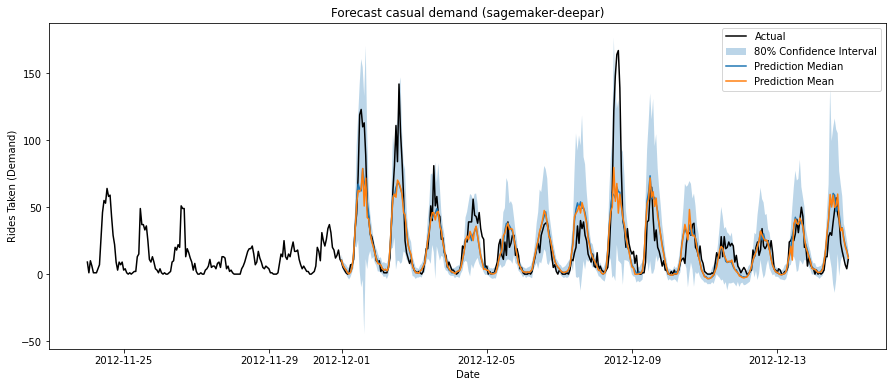

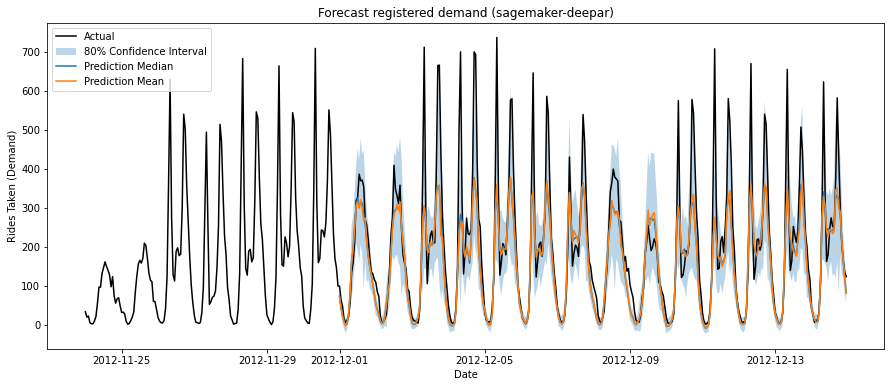

In [22]:
first_plot_dt = test_end_dt - timedelta(days=21)
actuals_plot_df = target_train_df.append(target_test_df)
actuals_plot_df["timestamp"] = pd.to_datetime(actuals_plot_df["timestamp"])
actuals_plot_df = actuals_plot_df[
    (actuals_plot_df["timestamp"] >= first_plot_dt)
    & (actuals_plot_df["timestamp"] < test_end_dt)
]
util.plot_fcst_results(actuals_plot_df, clean_results_df)

In [23]:
untuned_results_filename = results_local_filename
untuned_clean_results_df = clean_results_df
# !mv results/smdeepar/results_clean.csv results/smdeepar/results_clean_untuned.csv

## Step 8: Kick off a Hyperparameter Optimization to improve performance

위 하이퍼파라미터는 [DeepAR tuning documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html)와 데이터셋의 특성에 따라 어느 정도의 생각이 필요합니다.

이 파라미터를 튜닝하는 것은 다양한 순차적인 조합의 테스트가 오래 걸리기 때문에 많이 어렵습니다. grid search나 수동 탐색 방식은 계산 비용이나 노동력에 관계 없이 비용이 많이 듭니다.

SageMaker의 [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)을 활용할 수 있습니다. 이 방식은 높은 평가 비용의 최적화 문제를 위해 특별히 설계된 베이지안 최적화 방법을 사용합니다.

[HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html)의 `fit()` 방법은 `Estimator`와 같이 기본적으로 제공되지 않습니다. (HPO 작업은 일반적으로는 오래 걸리기 때문입니다.)

SageMaker console에 있는 "Hyperparameter Tuning Jobs"은 진행되는 작업의 상세 상태와 metrics를 확인하기에 좋은 UI를 제공합니다. 

**이 작업은 다음 섹션이 끝날 때까지 기다릴 필요가 없습니다.**

<h2><span style="color:red">아래 2개 값을 설정하시기 바랍니다.</span></h2>

In [24]:
max_jobs=4    # TODO: Ideally 12 or more
max_parallel_jobs=2   # TODO: Maybe only 1 for Event Engine, 2-3 if possible

In [25]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    #Alternative e.g. objective_metric_name="test:RMSE",
    objective_metric_name="test:mean_wQuantileLoss",
    hyperparameter_ranges={
        "mini_batch_size": sagemaker.tuner.IntegerParameter(1, 500),
        "context_length": sagemaker.tuner.IntegerParameter(10, round(24*14*1.1)),
        "num_cells": sagemaker.tuner.IntegerParameter(30, 200),
        "num_layers": sagemaker.tuner.IntegerParameter(1, 8),
    },
    objective_type="Minimize",
    # Defining the maximum number and parallelism of HPO training jobs:
    # Note that accounts have protective limits on number of GPU instances by default.
    # For Event Engine accounts, default max ml.p3.2xlarge = 2
    # Set max_parallel_jobs = (limit / train_instance_count) - 1
    # (minus one lets you run HPO and non-HPO in parallel)
    max_jobs=max_jobs,    # TODO: Ideally 12 or more
    max_parallel_jobs=max_parallel_jobs,    # TODO: Maybe only 1 for Event Engine, 2-3 if possible
    base_tuning_job_name="bike-demo-deepar-tuning"
)

tuner.fit(
    inputs={ "train": train_channel, "test": test_channel },
    wait=False
)

# Uncomment if you like locking up your notebook for hours:
# tuner.wait()

In [26]:
tuner.wait()

..................................................................................................................................................................................................................................................................................................................................................................................!


... 예측 결과를 우리가 Amazon Forecast에서 했던 동일한 표준 형태로 전환합니다.

## Step 9: Using our hyperparameter tuning job

SageMaker Console의 "Hyperparameter Tuning Jobs" 에서 하이퍼파라미터 튜닝 진행 상태를 확인해 보고, 몇 시간이 걸릴 수 있지만 최종적으로 화면에서 "Completed"을 확인할 수 있습니다.

console에서 직접 SageMaker에 모델 산출물을 등록해서 "create models"가 가능하며, 실시간 endpoints 배포 또는 batch transform jobs로 시작할 수도 있습니다.

Console의 UI에서의 설정 파라미터는 노트북에서 앞서 사용한 소스코드와 직접적으로 일치하지만, SDK의 `fit()`과 `deploy()` 와 관련해서는 Model과 Endpoint 구성 정보를 단순화하거나 줄여서 제공하고 있습니다.

**연습 : 가이드에 따라 이미 있는 `Inference > Models`와 `Inference > Batch transform jobs`을 사용하여, steps 3과 6에 코드를 재실행하면, console에서 동일 inference 데이터 셋에 대해 가장 좋은 HPO-tuned 모델을 실행할 수 있나요? **

Note:

* endpoint 배포가 아닌 batch transform job을 생성한 다음, 
* 이전 모델의 결과가 덮어쓰지 않게 하기 위해 새로운 transform job에 대한 다른 output 경로를 선택합니다. 이 경우 이전 경로의 **하위 폴더**로 output 경로를 정한 다음 Step 9 를 동작합니다.

<img src="BlogImages/HPOComplete.png"/>

## Step 10: Comparing HPO-tuned and best-guess performance

마지막 단계를 성공적으로 수행하고 학습 작업이 완료되며, S3의 bucket 내 새로운 `.out`를 확인할 수 있습니다.

우선적으로 이전 결과를 복사하시기 바랍니다.


In [27]:
from sagemaker.model import Model

In [28]:
client = boto3.client('sagemaker')
response = client.describe_training_job(
    TrainingJobName=tuner.best_training_job()
)

In [29]:
tuner_model = Model(training_image, 
                    model_data=response['ModelArtifacts']['S3ModelArtifacts'],
                    role=sm_role_arn)

In [30]:
tuner_transformer = tuner_model.transformer(
    instance_count=1, # We only have 2 "records" (customer types) - multi-instance would be overkill!
    instance_type="ml.c4.2xlarge", # Per the docs, DeepAR only uses CPU at inference time
    strategy="SingleRecord", # Send records to the model one at a time
    assemble_with="Line", # Join results with a newline in the output file (JSONLines)
    output_path=f"s3://{bucket}/results/smdeepar/hpo/",
    env={
        # We only want the p10, p50, p90 configs to compare with Amazon Forecast, so will override default output:
        "DEEPAR_INFERENCE_CONFIG": json.dumps({
            "num_samples": 100,
            "output_types": ["mean", "quantiles"],
            "quantiles": ["0.1", "0.5", "0.9"]
        })
    }
)
tuner_transformer.transform(
    f"s3://{bucket}/{data_prefix}smdeepar/{sm_inference_filename}",
    split_type="Line", # Records are separated by a newline in the input file (JSONLines)
    logs=True,
    wait=False
)

In [31]:
tuner_transformer.latest_transform_job.wait()

...............................Arguments: serve
Failed to set debug level to 20, using INFO
[05/22/2022 11:49:09 INFO 140438016522048] Estimated memory required per model 266.3569927215576MB.
[05/22/2022 11:49:09 INFO 140438016522048] Estimated available memory 13428.332889556885MB.
[05/22/2022 11:49:09 INFO 140438016522048] Estimated maximum number of workers for the available memory is 50.
[05/22/2022 11:49:09 INFO 140438016522048] Using 8 workers
[05/22/2022 11:49:09 INFO 140438016522048] loading entry points
[05/22/2022 11:49:09 INFO 140438016522048] Prediction endpoint operating in batch mode
[05/22/2022 11:49:09 INFO 140438016522048] loaded request iterator application/jsonlines
[05/22/2022 11:49:09 INFO 140438016522048] loaded response encoder application/jsonlines
[05/22/2022 11:49:09 INFO 140438016522048] loaded model class model
[05/22/2022 11:49:09 WARNING 140438016522048] Requesting context without setting the requested num of gpus. Using 'auto'
[05/22/2022 11:49:09 INFO 14

마지막으로 튜닝 전과 HPO 튜닝 후 결과를 통합하고 Amazon Forecasts에서 수행한 결과와 비교하는 그래프를 그립니다.

In [32]:
batch_hpo_results = tuner_transformer.output_path

!mkdir -p results/smdeepar/hpo
!aws s3 cp --recursive $batch_hpo_results results/smdeepar/hpo
print("SMDeepAR results folder contents:")
!ls results/smdeepar/hpo

download: s3://forecast-demolab-cyj-220524/results/smdeepar/hpo/predict_input.json.out to results/smdeepar/hpo/predict_input.json.out
SMDeepAR results folder contents:
predict_input.json.out


In [33]:
results_local_filename = f"results/smdeepar/hpo/{sm_inference_filename}.out"
results_raw = []
with open(results_local_filename) as f:
    for line in f:
        results_raw.append(json.loads(line))

# Note the order of records (hence the correspondence to customer_types) is preserved in SM batch:
assert (
    len(results_raw) == len(customer_types)
), "Mismatch: Batch transform should return one prediction per customer type!"

In [34]:
model_id = "sagemaker-deepar"

first_test_ts = target_test_df["timestamp"].iloc[0]
test_start_dt = datetime(
    int(first_test_ts[0:4]),
    int(first_test_ts[5:7]),
    int(first_test_ts[8:10]),
    int(first_test_ts[11:13]),
    int(first_test_ts[14:16]),
    int(first_test_ts[17:])
)
test_end_dt = test_start_dt + timedelta(days=14)

# Timestamps aren't listed in the DeepAR output, so we synthesize them from the test data:
test_df = target_test_df.copy()
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df = test_df[test_df["timestamp"] < test_end_dt]
ctype_test_dfs = {
    ctype: test_df[test_df["customer_type"] == ctype]
for ctype in customer_types}

clean_results_df = pd.DataFrame()
for ix in range(len(customer_types)):
    prediction = results_raw[ix]

    df = pd.DataFrame()
    df["timestamp"] = ctype_test_dfs[customer_types[ix]]["timestamp"]
    df["model"] = model_id+'-hpo'
    df["customer_type"] = customer_types[ix]
    df["mean"] = prediction["mean"]
    df["p10"] = prediction["quantiles"]["0.1"]
    df["p50"] = prediction["quantiles"]["0.5"]
    df["p90"] = prediction["quantiles"]["0.9"]

    clean_results_df = clean_results_df.append(df)

clean_results_df.to_csv(
    f"./results/smdeepar/hpo/results_clean_hpo.csv",
    index=False
)
print("Clean results saved to ./results/smdeepar/hpo/results_clean_hpo.csv")
clean_results_df.head()

Clean results saved to ./results/smdeepar/hpo/results_clean_hpo.csv


,timestamp,model,customer_type,mean,p10,p50,p90
0,2012-12-01 00:00:00,sagemaker-deepar-hpo,casual,11.032721,6.020189,11.544808,16.071285
2,2012-12-01 01:00:00,sagemaker-deepar-hpo,casual,9.207400,4.952633,9.629629,13.141184
4,2012-12-01 02:00:00,sagemaker-deepar-hpo,casual,7.709623,3.628338,7.296042,12.016625
6,2012-12-01 03:00:00,sagemaker-deepar-hpo,casual,4.167706,-0.335645,4.400690,8.569174
8,2012-12-01 04:00:00,sagemaker-deepar-hpo,casual,2.016172,-1.285370,2.403766,4.827451


In [35]:
# !cp -r results/smdeepar/untuned/results_clean.csv results/smdeepar/results_clean_untuned.csv
# !cp -r results/smdeepar/hpo/results_clean.csv results/smdeepar/results_clean_hpo.csv

comparison_results_df = untuned_clean_results_df.append(clean_results_df)

comparison_results_df.to_csv(
    f"./results/smdeepar/results_clean.csv",
    index=False
)
print("Full results saved to ./results/smdeepar/results_clean.csv")
comparison_results_df.head()

Full results saved to ./results/smdeepar/results_clean.csv


,timestamp,model,customer_type,mean,p10,p50,p90
0,2012-12-01 00:00:00,sagemaker-deepar,casual,10.341550,6.391323,10.502525,14.691136
2,2012-12-01 01:00:00,sagemaker-deepar,casual,6.462347,3.063007,6.598311,9.499372
4,2012-12-01 02:00:00,sagemaker-deepar,casual,4.641456,1.187759,4.459270,7.989873
6,2012-12-01 03:00:00,sagemaker-deepar,casual,3.110479,0.067593,3.170413,7.026835
8,2012-12-01 04:00:00,sagemaker-deepar,casual,1.004420,-2.294647,1.159878,5.067968


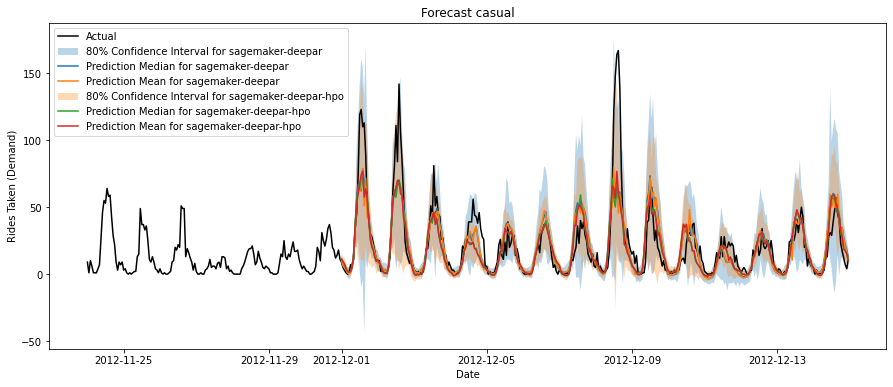

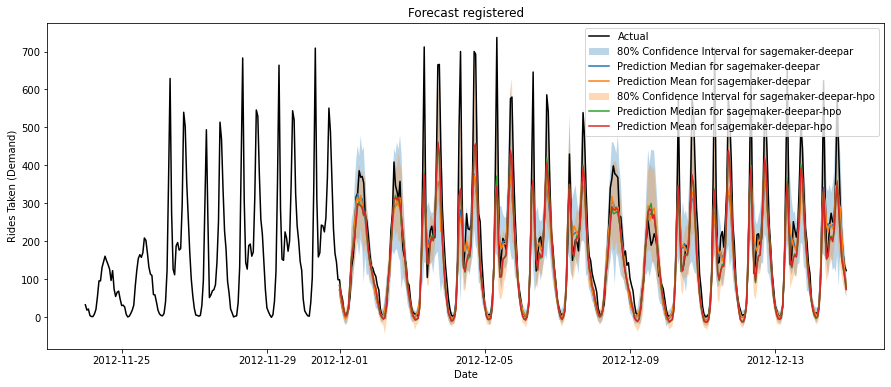

In [36]:
util.plot_fcst_merge_results(actuals_plot_df, comparison_results_df)

비교시 업데이트된 그래프는 어떠한가요? 모델이 개선되었나요?

console에서 hyperparameter tuning job의 metrics 결과와 일반적인 학습 작업의 결과는 어떠한가요? 양적인 변화가 있나요?

## Extension exercises and exploring further

Amazon Forecast와 같이 튜닝 전 또는 HPO로 튜닝한 결과 모두 표준 형식으로 저장되어 있습니다.

Test 데이터셋 성능을 수치화하기 위해 RMSE와 가중 quantile 손실 metrics를 계산할 수 있나요?

Amazon Forecast과 SageMaker DeepAR 접근의 상대적인 강점과 약점은 무엇일까요?

하루까지 timestamps를 이동할 경우나 `holiday`와 `workingday` 값을 삭제했을 경우에 SageMaker DeepAR가 Amazon Forecast와 동일한 민감도를 갖나요?


## Thanks for joining in! (Clean-up time)

Amazon Forecast와 같이 이 워크삽에서는 실시간 predictor endpoint로 배포하지 않습니다. 
하지만 몇개의 산출물을 생성했기 때문에 데이터 스토리지 비용이 중요한 경우에는 이를 정리할 필요는 있습니다.Amazon SageMaker 의 왼쪽 메뉴의 탭들과, S3 bucket을 반드시 확인하고 원치 않을 경우 정리하는 것이 필요합니다.

항상 그렇듯이 SageMaker 노트북을 더이상 사용하지 않으면 중지해야 합니다.